In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import models
import time
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import copy

# ============================================================
# 1. Load Dataset and Data Set Preparation
# ============================================================

In [3]:
# a. Preprocess and Normalization
# -----------------------------
# Data transformation is used to change raw data into a format suitable for the model.
# Data augmentation is performed on the training dataset to improve model generalization.

IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# These values are mostly used by researchers as found to very useful in fast convergence

# We can try various transformation for good generalization of model
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),            # Random Crop augmentation to increase spatial variation
        transforms.RandomHorizontalFlip(p=0.5),          # Horizontal flip with higher probability (0.5)
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Jitter for color variations
        transforms.ToTensor(),                           # Convert to tensor
        transforms.Normalize([0.4914, 0.4822, 0.4465],   # CIFAR-10 specific normalization
                             [0.2023, 0.1994, 0.2010]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), value=1.0)  # Erasing with lower probability
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [18]:
# b. Download and Load CIFAR-10 Dataset
# -------------------------------------

# Download and load the training dataset
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Download and load the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# c. Split Dataset into Training, Validation, and Test Set
# -----------------------------------------------------------
# Split the training dataset into training set and validation set.

# Determine the size of the training and validation datasets
train_size = int(0.8 * len(train_dataset_full))  # 80% for training
val_size = len(train_dataset_full) - train_size   # 20% for validation

# Split dataset
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# ================================================================
# 2. DataLoader for Batch Processing
# ================================================================
# DataLoader is used to load data in batches during training.

In [20]:
# Set batch size
batch_size = 512

# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ================================================================
# 3. Model Building based on CNN Architecture (RESNET, MOBILENET, ALEXNET)
# ================================================================

In [21]:
class AlexNet_CIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_CIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),  # Batch Normalization
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 512),
            nn.BatchNorm1d(512),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [22]:
# a. Loading the model without pre-trained weights
# -----------------------------------------
# Using a model trained from scratch without pre-trained weights.

# Number of classes in CIFAR-10
num_classes = 10

# 1. Loading ResNet-18 without pre-trained weights
resnet18 = models.resnet18(pretrained=False)
# Adjust input and output for CIFAR-10
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet18.maxpool = nn.Identity()  # Remove maxpool to preserve dimensions
num_ftrs_resnet = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs_resnet, num_classes)

# 2. Loading AlexNet without pre-trained weights
alexnet = AlexNet_CIFAR10(num_classes=num_classes)

# 3. Loading MobileNet_v2 without pre-trained weights
mobilenet = models.mobilenet_v2(pretrained=False)
# Adjusting the final classifier for CIFAR-10
num_ftrs_mobilenet = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs_mobilenet, num_classes)
)

In [23]:
# b. Save the model to a file
# --------------------------
# Save the model for reuse or future inference.

# Create a directory to store the model if it doesn't already exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

torch.save(resnet18.state_dict(), 'saved_models/resnet18_initial.pth')
torch.save(alexnet.state_dict(), 'saved_models/alexnet_initial.pth')
torch.save(mobilenet.state_dict(), 'saved_models/mobilenet_initial.pth')

In [24]:
# c. Move the model to the device (GPU if available)
# -------------------------------------------------
# Make sure the model uses GPU if available to speed up the training process.

# Determine the device to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
resnet18 = resnet18.to(device)
alexnet = alexnet.to(device)
mobilenet = mobilenet.to(device)

# =================================================================
# 4. Definition of Loss Function, Optimizer, and Scheduler
# =================================================================

In [25]:
# a. Loss Function
# ----------------
# Using CrossEntropyLoss because this problem is multi-class classification.

criterion = nn.CrossEntropyLoss()

In [26]:
# SETTING TESTING VARIATIONS

# Define learning rates for experiments
learning_rates = [0.01,0.001,0.0001]

# List of optimizers
optimizers_list = ['adam', 'sgd', 'rmsprop']

# EPOCH 
epoch = 50

In [27]:
# b. Optimizer
# ------------
# Using Adam optimizer with different learning rates for experimentation.

# Define functions to create optimizer and scheduler
def create_optimizer_and_scheduler(model, optimizer_type, lr):
    # Optimizer options with weight_decay settings to reduce overfitting
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    else:
        raise ValueError(f"Unknown optimizer type: {optimizer_type}")

    # Use MultiStepLR or StepLR
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)
    
    return optimizer, scheduler

# Initialize a dictionary to store the optimizer and scheduler
optimizers = {}

# Loop through each learning rate and optimizer
for lr in learning_rates:
    for model_name, model in zip(['resnet', 'alexnet', 'mobilenet'], [resnet18, alexnet, mobilenet]):
        for optimizer_type in optimizers_list:
            optimizer, scheduler = create_optimizer_and_scheduler(model, optimizer_type, lr)
            key = f'{model_name}_{optimizer_type}_lr_{lr}'
            optimizers[key] = (optimizer, scheduler)

# ==============================================================
# 5. Functions for Training and Evaluating Models
# ==============================================================

In [28]:
def train_and_evaluate_model(model, optimizer, scheduler, num_epochs=30, model_name='', lr=0.001, patience=5, min_delta=0.001):
    """
    Function to train a model and evaluate it on the validation set every epoch with additional Early Stopping and Model Checkpointing.

    Parameters:
    - model: the model to be trained
    - optimizer: the optimizer used
    - scheduler: the scheduler for learning rate
    - num_epochs: number of epochs for training
    - model_name: model name (for logging)
    - lr: learning rate (for logging)
    - patience: number of epochs without improvement to stop training
    - min_delta: minimum improvement to be considered as improvement

    Returns:
    - model: the best model based on validation accuracy
    - train_loss_history: list of losses on the training set every epoch
    - train_acc_history: list of accuracies on the training set every epoch
    - val_loss_history: list of losses on the validation set every epoch
    - val_acc_history: list of accuracies on the validation set every epoch
    """
    # Initialize a list to store history
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []
    epoch_durations = []

    # Save the best model weight
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping has been activated. Stop training.")
            break

        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs} - {model_name} - LR: {lr}')
        print('-' * 60)

        # -------------------------------------------------------
        # Training Phase
        # -------------------------------------------------------
        model.train()  # Set model to training mode
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Update scheduler
        scheduler.step()

        # Calculate the loss and accuracy of this epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # -------------------------------------------------------
        # Validation Phase
        # -------------------------------------------------------
        model.eval()  # Set the model to evaluation mode
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move data to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Statistics
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        # Calculate loss and accuracy on validation set
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        end_time = time.time()
        epoch_duration = end_time - start_time
        epoch_durations.append(epoch_duration)

        # Logging
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        print(f'Epoch Duration: {epoch_duration:.2f} seconds\n')

        # Check validation improvements
        if val_epoch_acc > best_acc + min_delta:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            # Save the best models
            torch.save(model.state_dict(), f'saved_models/{model_name.lower()}_best.pth')
            #print(f'--> Validation enhancement detected. Model saved.')
        else:
            epochs_no_improve += 1
            #print(f'--> No validation improvements during period {epochs_no_improve}.')
            if epochs_no_improve >= patience:
                print(f'Early termination is activated after a {patience} epochs without increments.')
                early_stop = True

    # Load the best model
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

# =================================================================
# 6. Functions for Evaluation on Test Set and Analysis
# =================================================================

In [1]:
def evaluate_model(model, model_name=''):
    """
    Function to evaluate the model on the test set and display analysis such as
    confusion matrix and classification report.

    Parameters:
    - model: the model to be evaluated
    - model_name: model name (for logging)

    Returns:
    - test_accuracy: accuracy on the test set
    """
    model.eval()  # Set the model to evaluation mode
    test_running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Statistics
            test_running_corrects += torch.sum(preds == labels.data)

            # Save predictions and labels for analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = test_running_corrects.double() / len(test_loader.dataset)
    

    return test_accuracy.item()

# =================================================================
# 7. Deep Learning Training and Hyperparameter Experiments
# =================================================================

In [30]:
# Initialize dictionary to store history
history = {}

# Early Stopping Parameters
patience = 7 # Number of epochs without improvement before stopping
min_delta = 0.001 # Minimum improvement

# Loop through each learning rate and optimizer for experimentation
for lr in learning_rates:
    for opt in optimizers_list:
        # ------------------------------------------------- ------
        # a. ResNet-18 Training
        # ------------------------------------------------- ------
        print(f"\nTraining ResNet-18 with Optimizer {opt.upper()} and Learning Rate {lr}:")
        # Reset model to initial weights
        resnet18.load_state_dict(torch.load('saved_models/resnet18_initial.pth'))
        resnet18 = resnet18.to(device)

        # Get optimizer and scheduler
        optimizer_resnet, scheduler_resnet = optimizers[f'resnet_{opt}_lr_{lr}']

        # Train the model
        resnet18_trained, resnet18_train_loss, resnet18_train_acc, resnet18_val_loss, resnet18_val_acc = train_and_evaluate_model(
            resnet18, optimizer_resnet, scheduler_resnet, num_epochs=epoch, model_name='ResNet-18', lr=lr, patience=patience, min_delta=min_delta)

        # Save the best model if it is not already saved in the function
        torch.save(resnet18_trained.state_dict(), f'saved_models/resnet18_{opt}_best_lr_{lr}.pth')


        # Save history
        history[f'resnet18_{opt}_lr_{lr}'] = {
            'train_loss': resnet18_train_loss,
            'train_acc': resnet18_train_acc,
            'val_loss': resnet18_val_loss,
            'val_acc': resnet18_val_acc,
        }

        # ------------------------------------------------- ------
        #b. AlexNet Training
        # ------------------------------------------------- ------
        print(f"\nTraining AlexNet with Optimizer {opt.upper()} and Learning Rate {lr}:")
        # Reset model to initial weights
        alexnet.load_state_dict(torch.load('saved_models/alexnet_initial.pth'))
        alexnet = alexnet.to(device)

        # Get optimizer and scheduler
        optimizer_alexnet, scheduler_alexnet = optimizers[f'alexnet_{opt}_lr_{lr}']

        # Train the model
        alexnet_trained, alexnet_train_loss, alexnet_train_acc, alexnet_val_loss, alexnet_val_acc = train_and_evaluate_model(
            alexnet, optimizer_alexnet, scheduler_alexnet, num_epochs=epoch, model_name='AlexNet', lr=lr, patience=patience, min_delta=min_delta)

        # Save the best model if it is not already saved in the function
        torch.save(alexnet_trained.state_dict(), f'saved_models/alexnet_{opt}_best_lr_{lr}.pth')


        # Save history
        history[f'alexnet_{opt}_lr_{lr}'] = {
            'train_loss': alexnet_train_loss,
            'train_acc': alexnet_train_acc,
            'val_loss': alexnet_val_loss,
            'val_acc': alexnet_val_acc,
        }

        # ------------------------------------------------- ------
        #c. MobileNet Training
        # ------------------------------------------------- ------
        print(f"\nTraining MobileNet with Optimizer {opt.upper()} and Learning Rate {lr}:")
        # Reset model to initial weights
        mobilenet.load_state_dict(torch.load('saved_models/mobilenet_initial.pth'))
        mobilenet = mobilenet.to(device)

        # Get optimizer and scheduler
        optimizer_mobilenet, scheduler_mobilenet = optimizers[f'mobilenet_{opt}_lr_{lr}']

        # Train the model
        mobilenet_trained, mobilenet_train_loss, mobilenet_train_acc, mobilenet_val_loss, mobilenet_val_acc = train_and_evaluate_model(
            mobilenet, optimizer_mobilenet, scheduler_mobilenet, num_epochs=epoch, model_name='MobileNet', lr=lr, patience=patience, min_delta=min_delta)

        # Save the best model if it is not already saved in the function
        torch.save(mobilenet_trained.state_dict(), f'saved_models/mobilenet_{opt}_best_lr_{lr}.pth')

        # Save history
        history[f'mobilenet_{opt}_lr_{lr}'] = {
            'train_loss': mobilenet_train_loss,
            'train_acc': mobilenet_train_acc,
            'val_loss': mobilenet_val_loss,
            'val_acc': mobilenet_val_acc,
        }

# After training, you can save history for further analysis
import json

with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=4)

print("Training completed and history saved.")


Training ResNet-18 with Optimizer ADAM and Learning Rate 0.01:
Epoch 1/50 - ResNet-18 - LR: 0.01
------------------------------------------------------------
Train Loss: 2.0810, Train Acc: 0.2579
Val Loss: 2.0243, Val Acc: 0.2343
Epoch Duration: 25.46 seconds

Epoch 2/50 - ResNet-18 - LR: 0.01
------------------------------------------------------------
Train Loss: 1.6848, Train Acc: 0.3678
Val Loss: 1.7279, Val Acc: 0.3531
Epoch Duration: 25.79 seconds

Epoch 3/50 - ResNet-18 - LR: 0.01
------------------------------------------------------------
Train Loss: 1.4672, Train Acc: 0.4546
Val Loss: 1.6314, Val Acc: 0.3873
Epoch Duration: 25.76 seconds

Epoch 4/50 - ResNet-18 - LR: 0.01
------------------------------------------------------------
Train Loss: 1.2939, Train Acc: 0.5237
Val Loss: 1.6603, Val Acc: 0.3858
Epoch Duration: 25.64 seconds

Epoch 5/50 - ResNet-18 - LR: 0.01
------------------------------------------------------------
Train Loss: 1.1711, Train Acc: 0.5772
Val Loss: 1

# =================================================================
# 8. Plot Training and Analysis Results
# =================================================================

In [31]:
# a. Function to plot accuracy and loss
def plot_metrics(train_acc, val_acc, train_loss, val_loss, model_name, lr):
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()




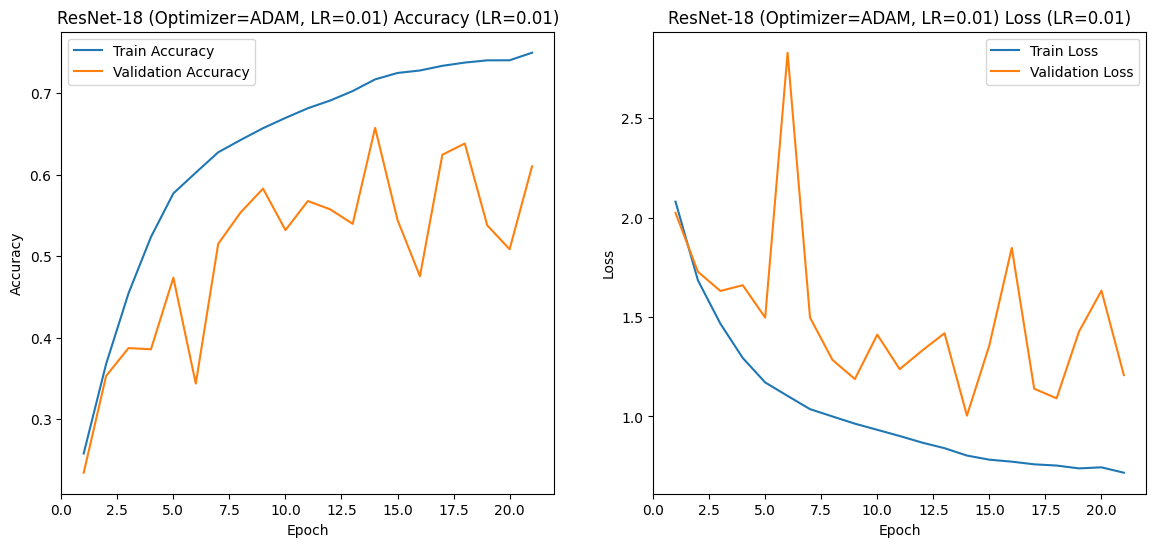

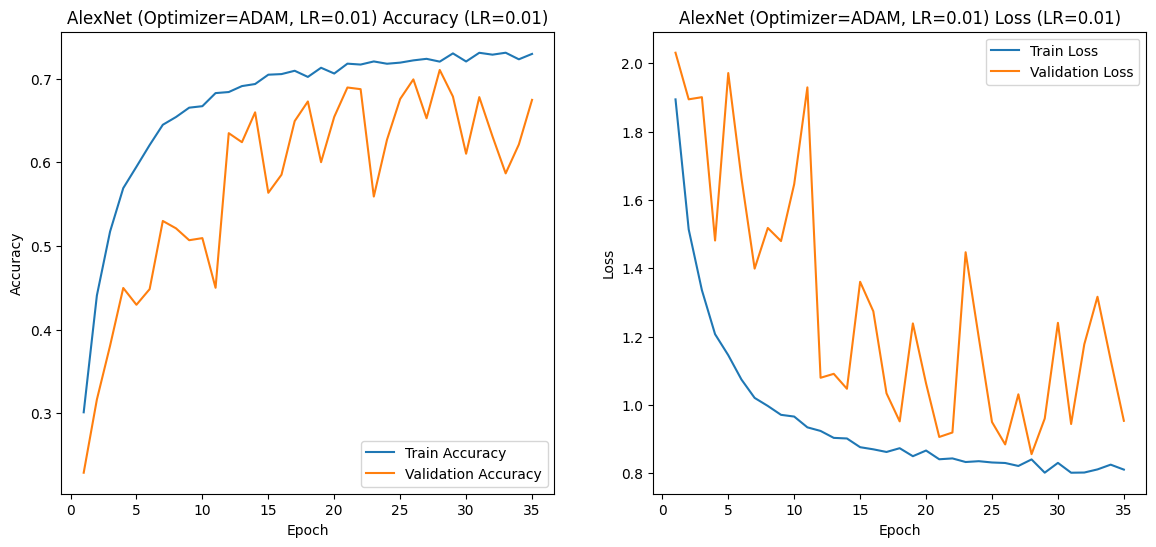

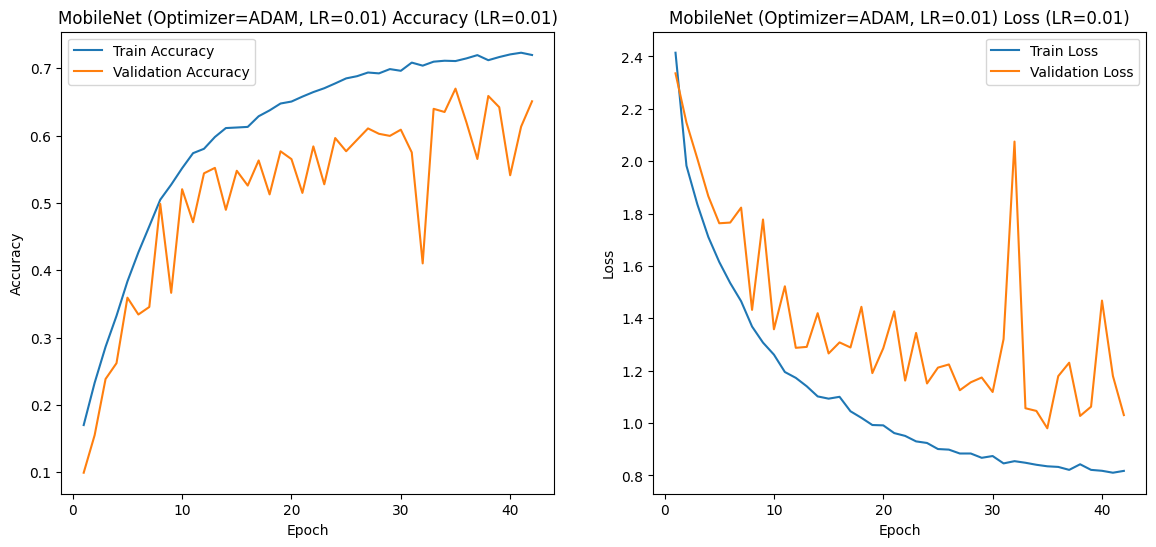

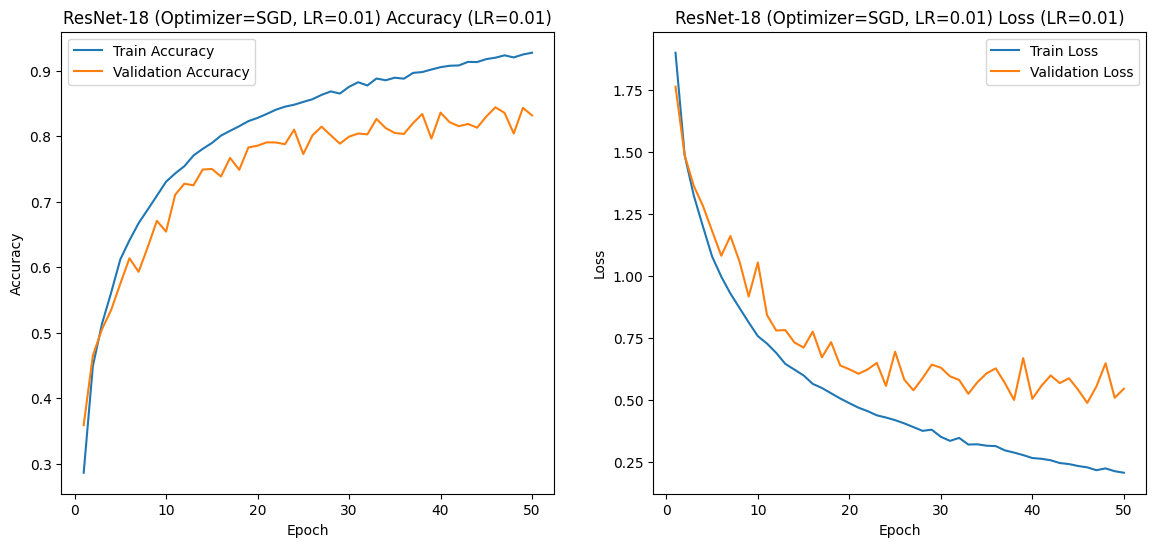

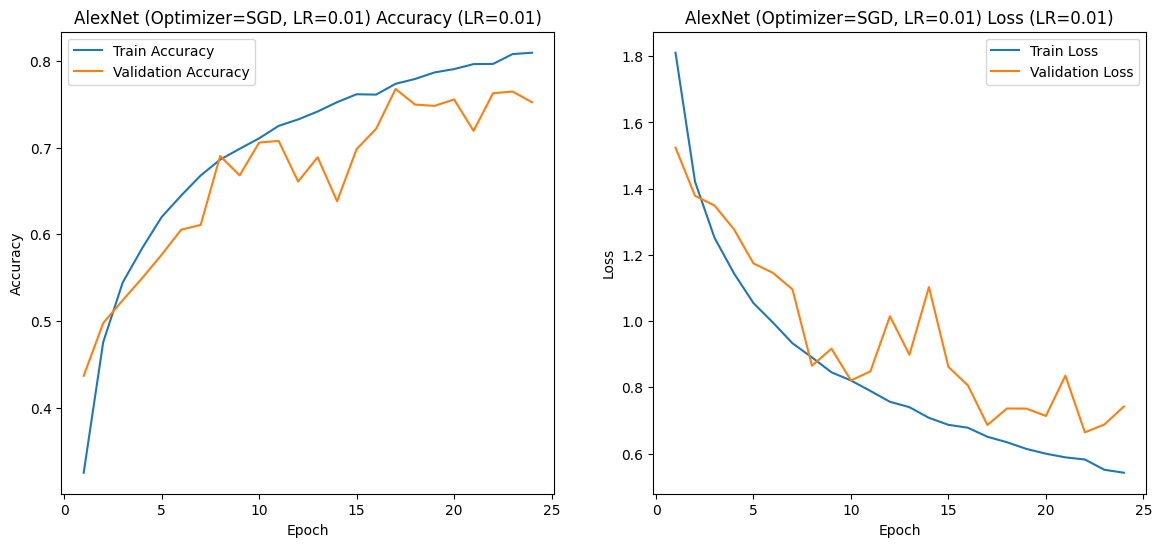

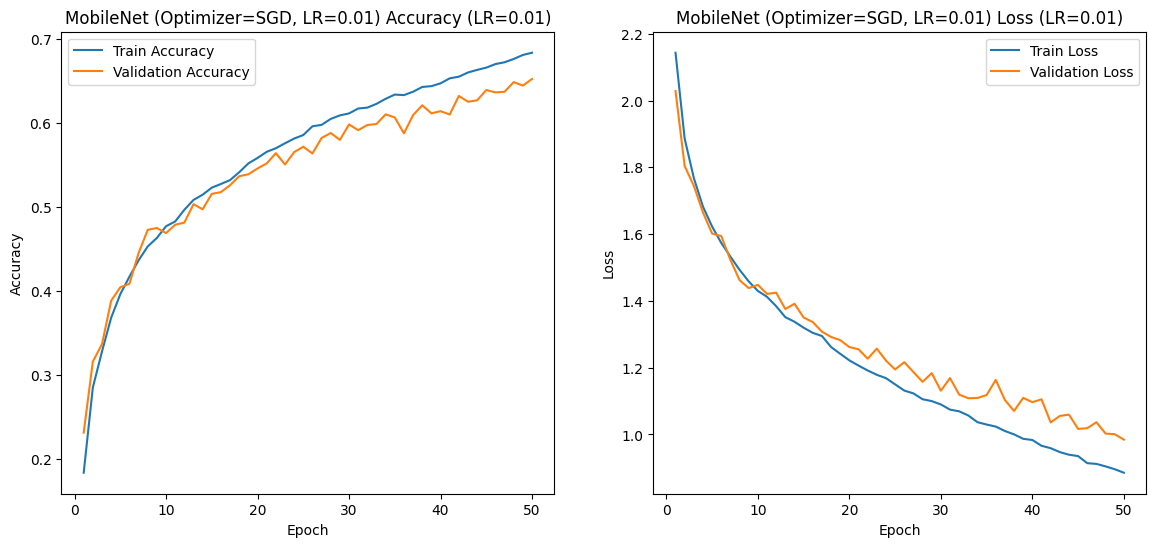

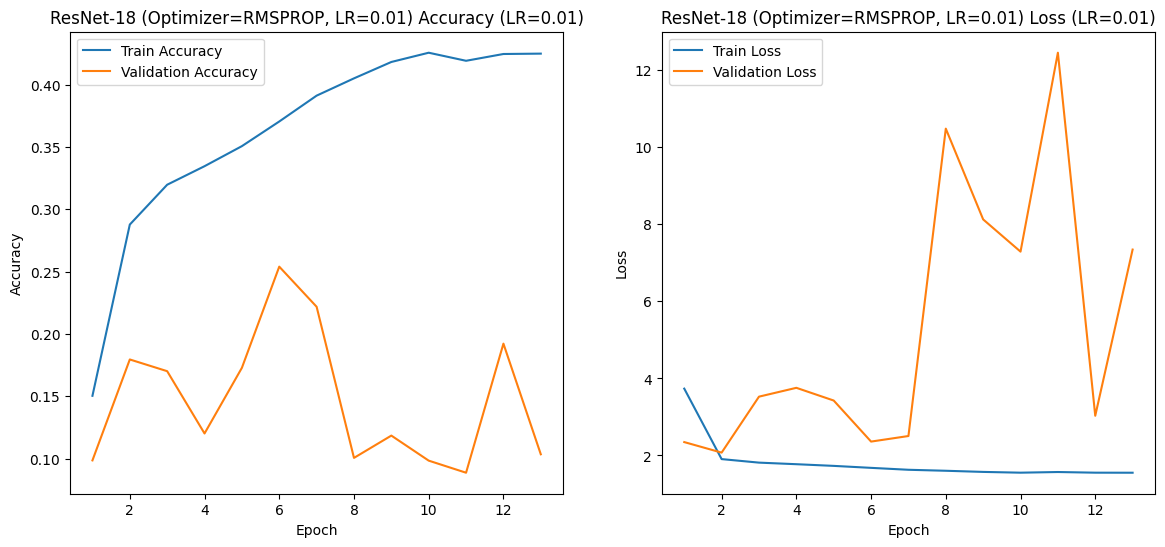

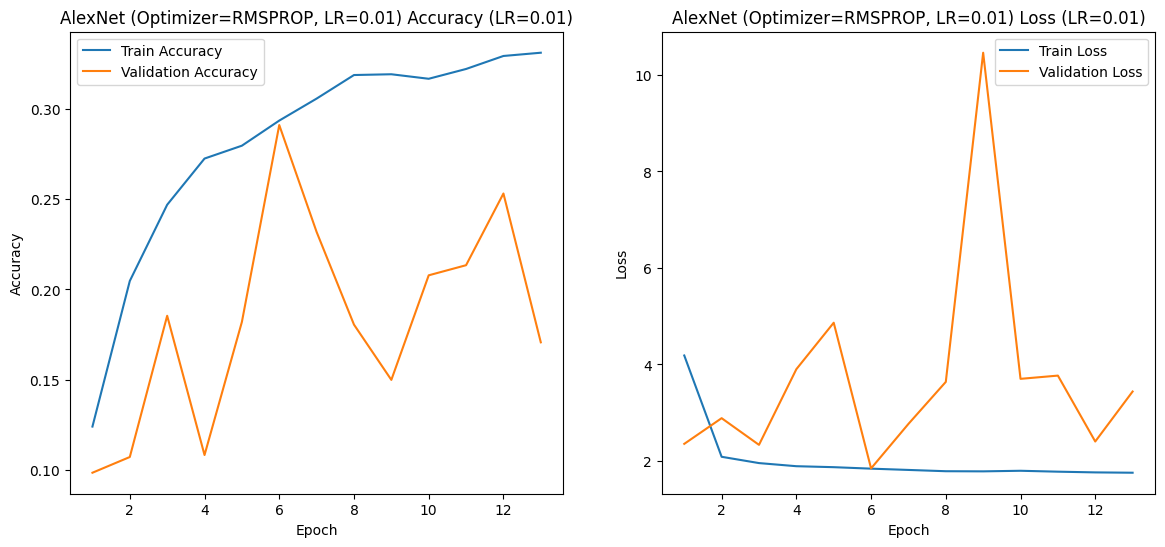

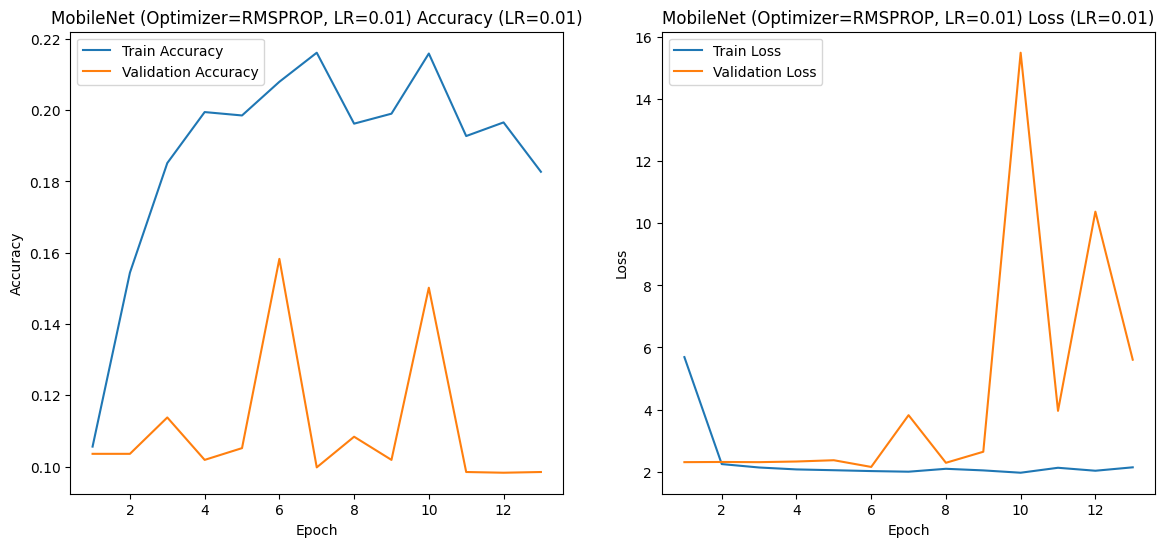

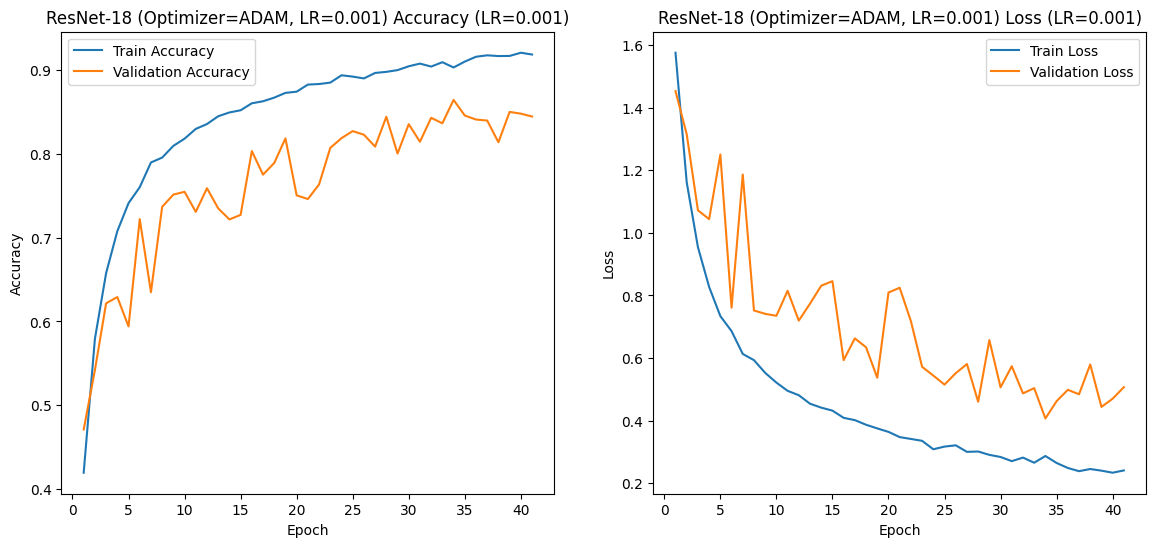

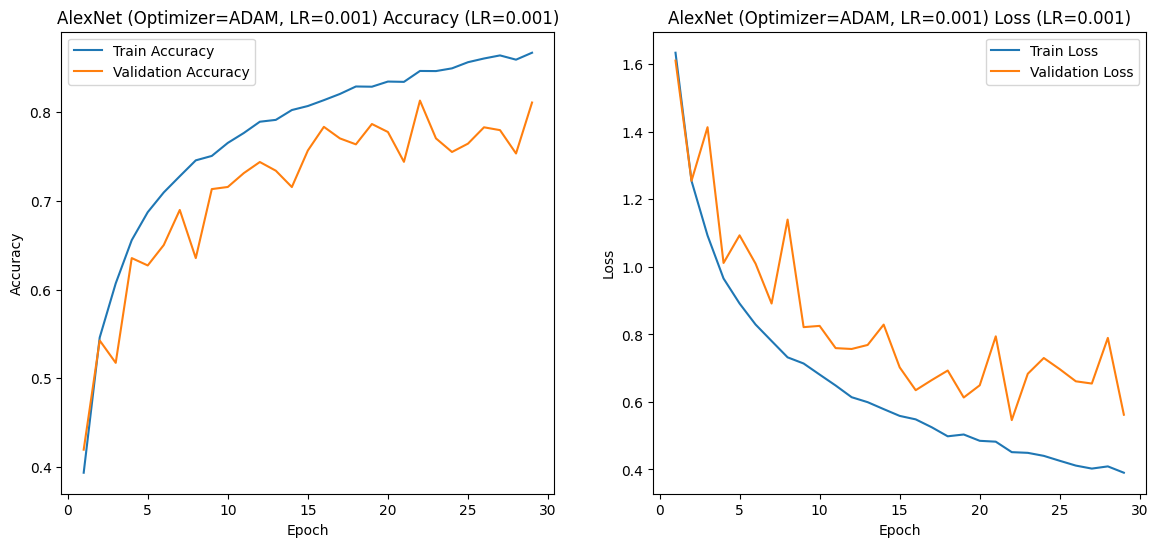

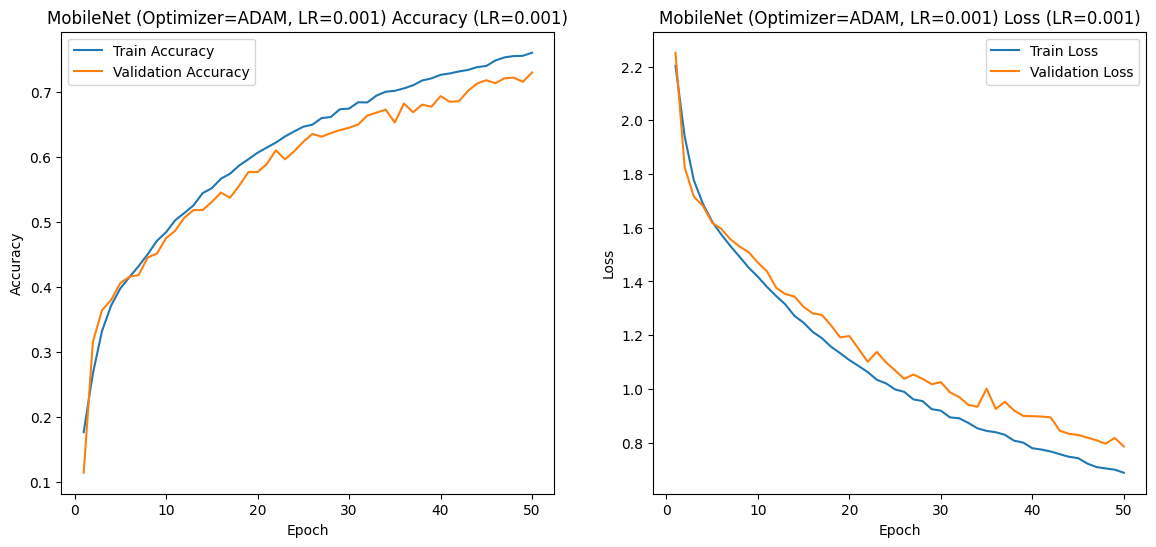

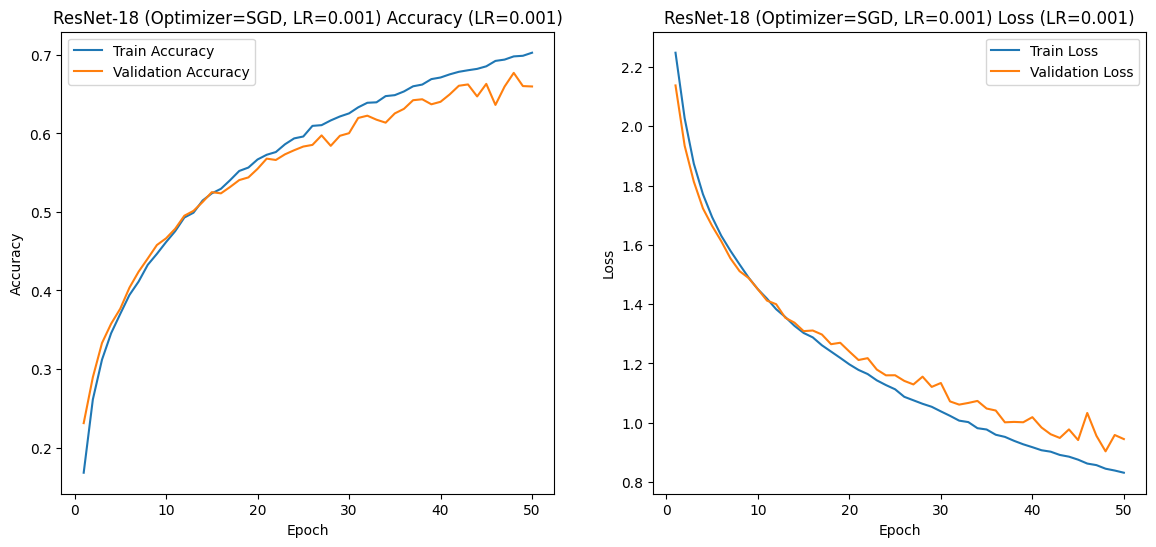

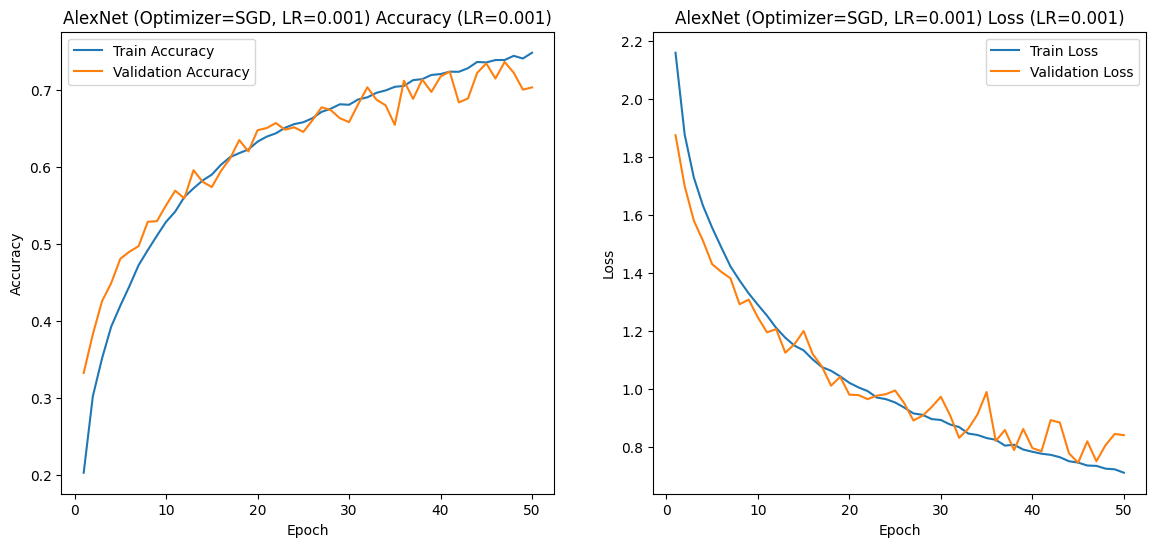

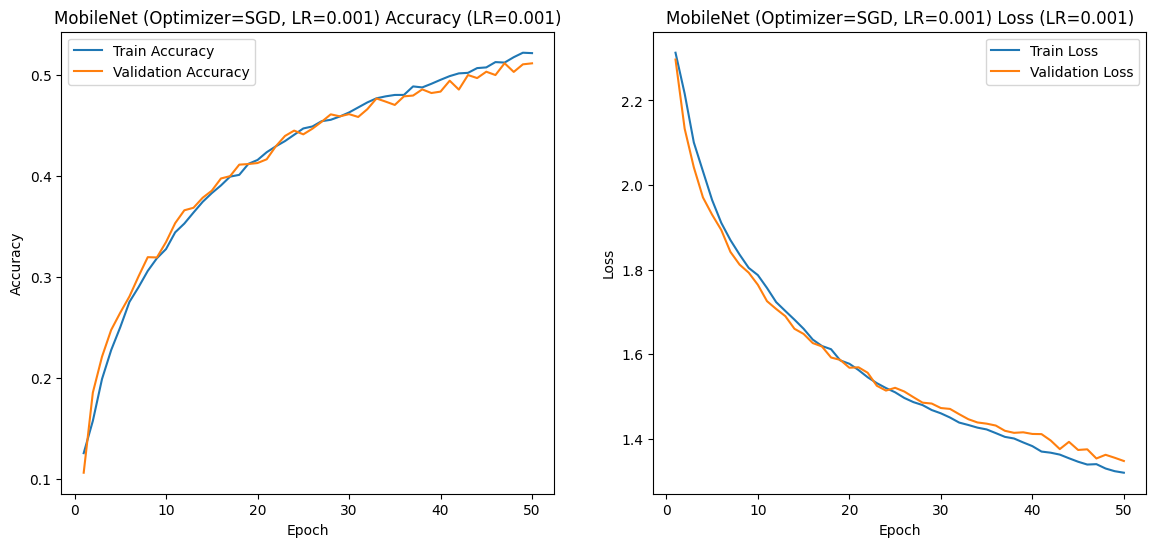

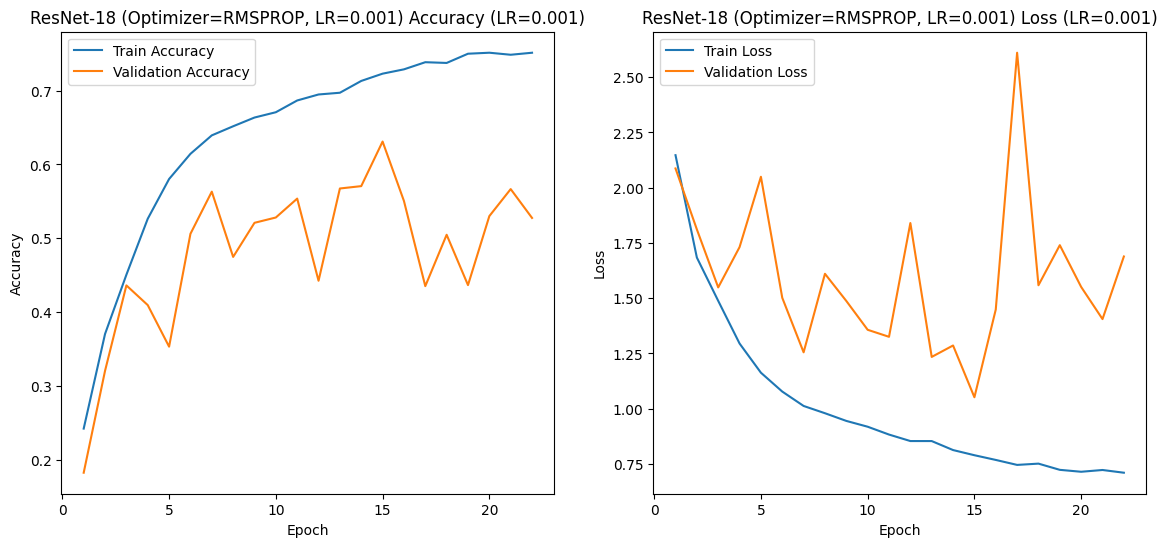

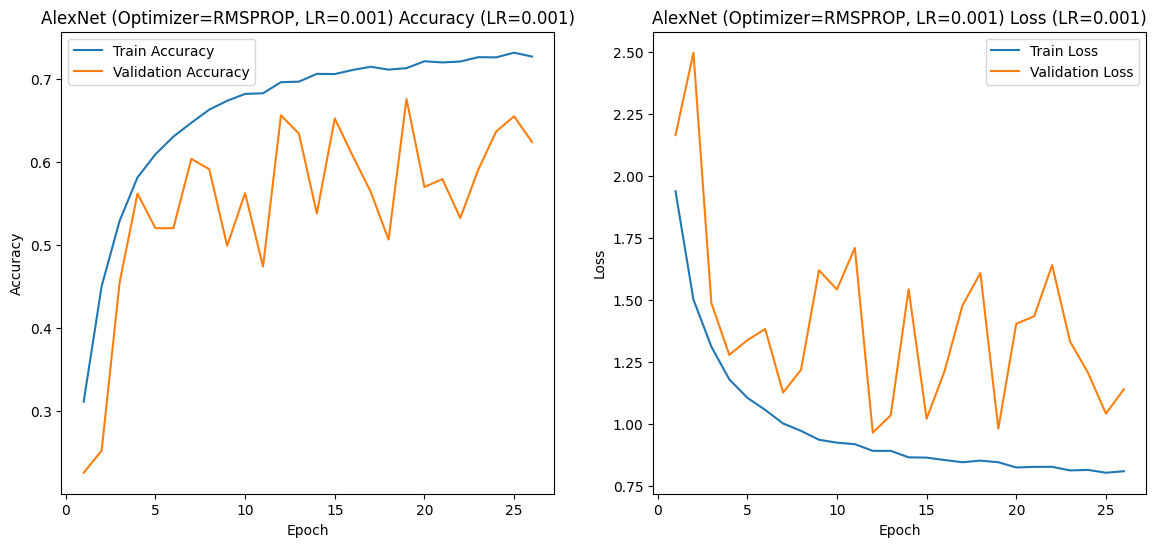

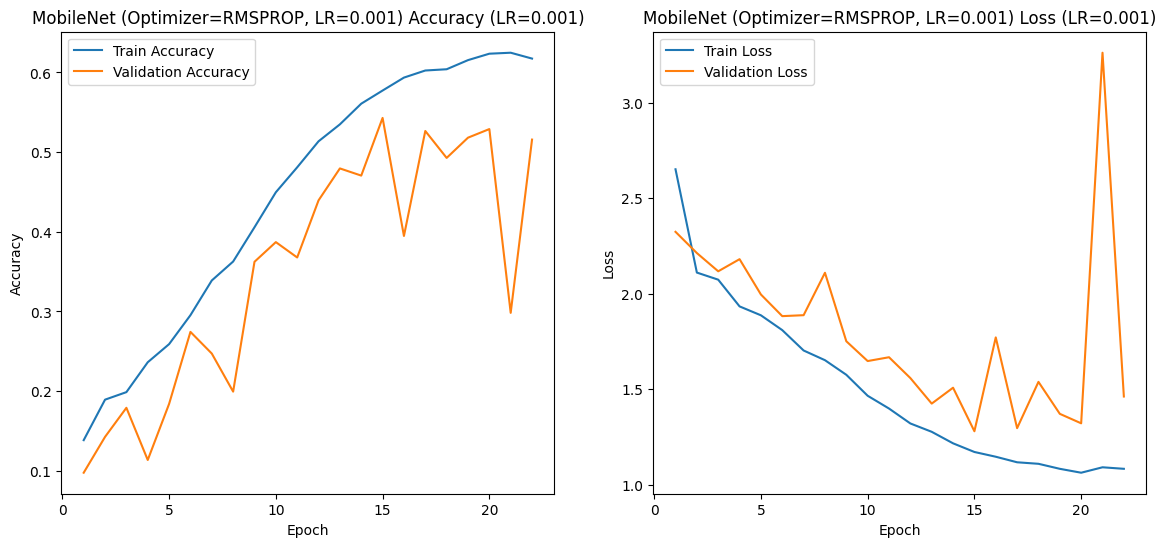

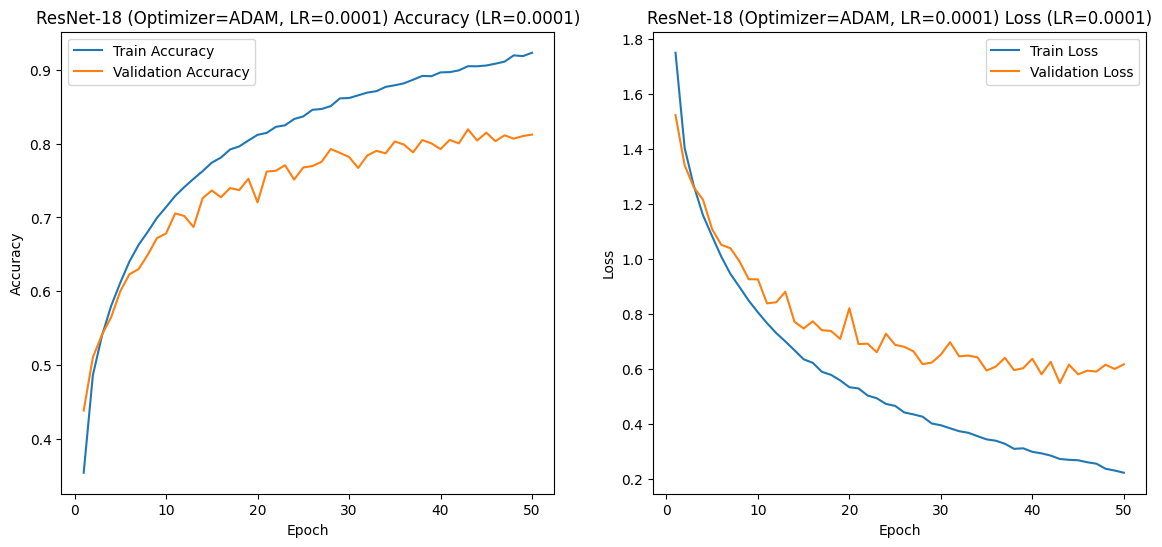

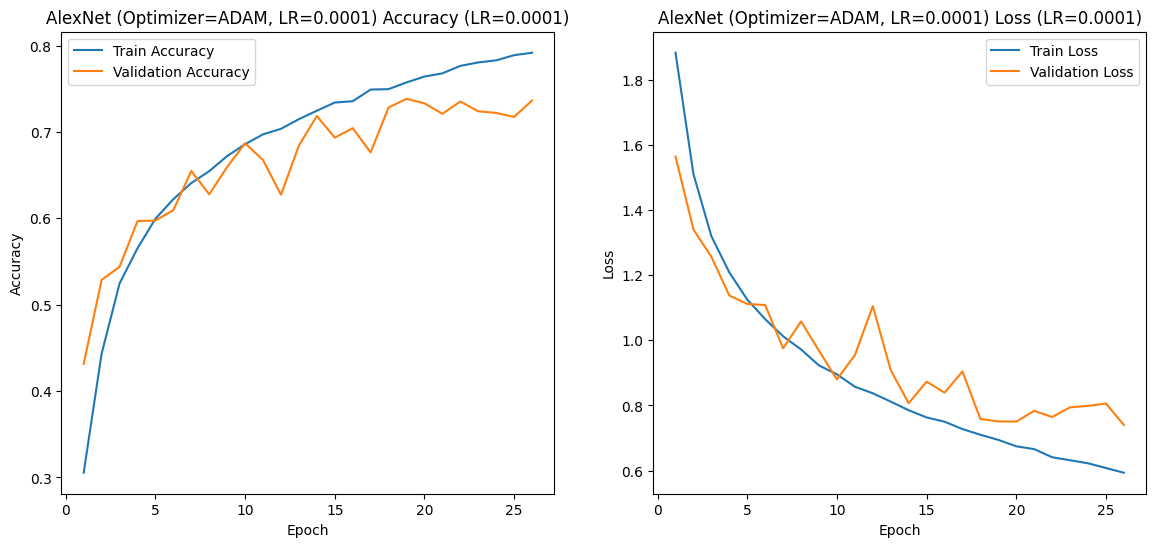

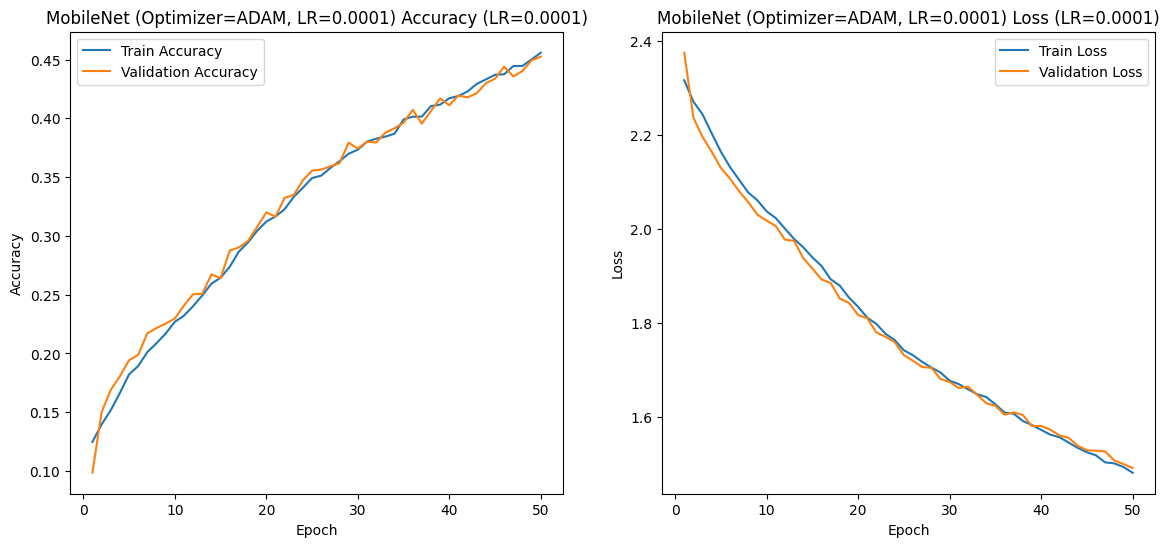

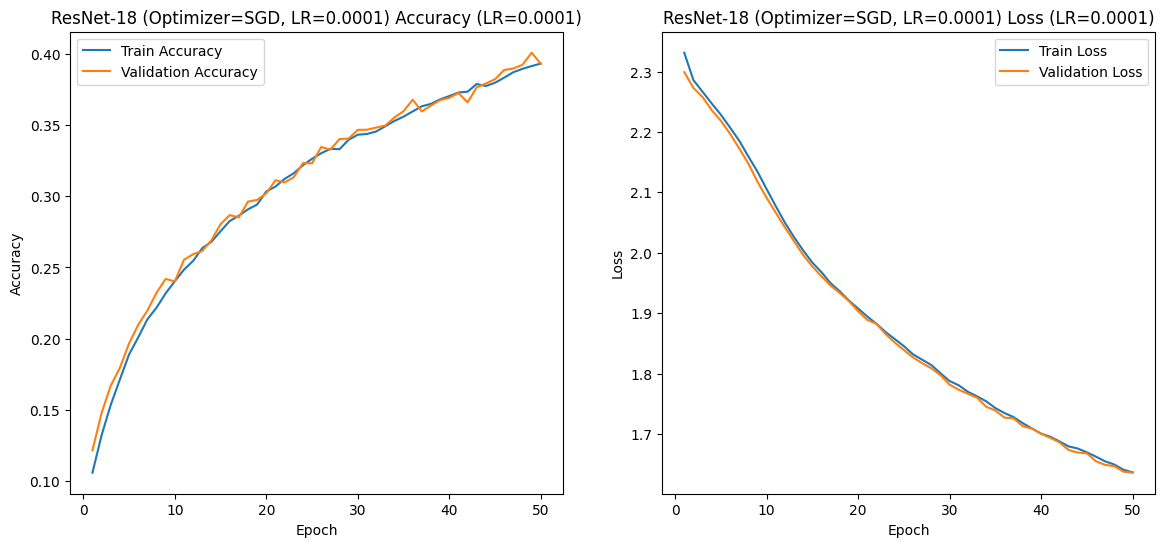

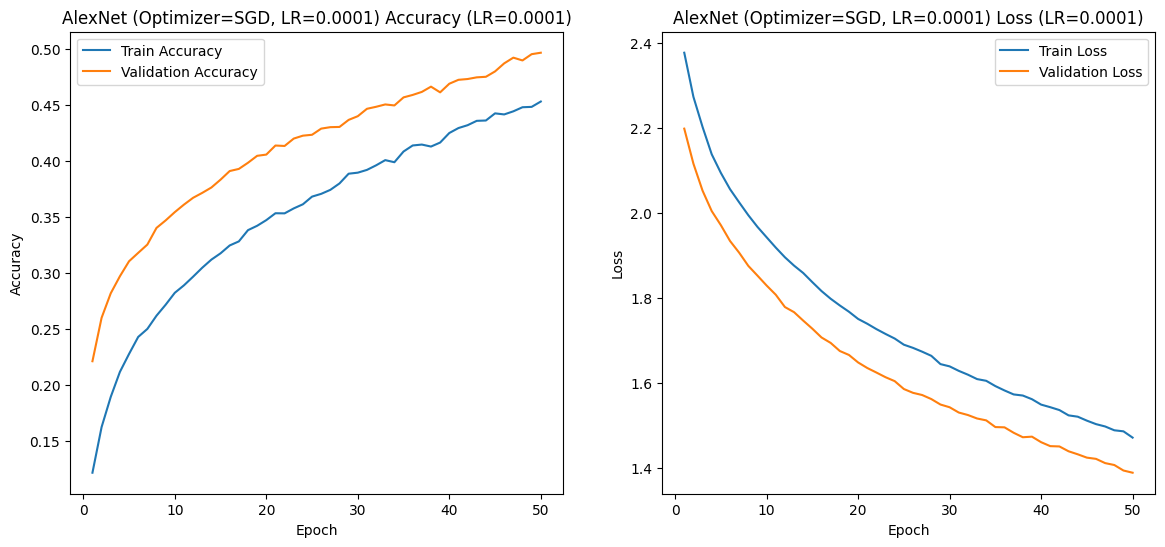

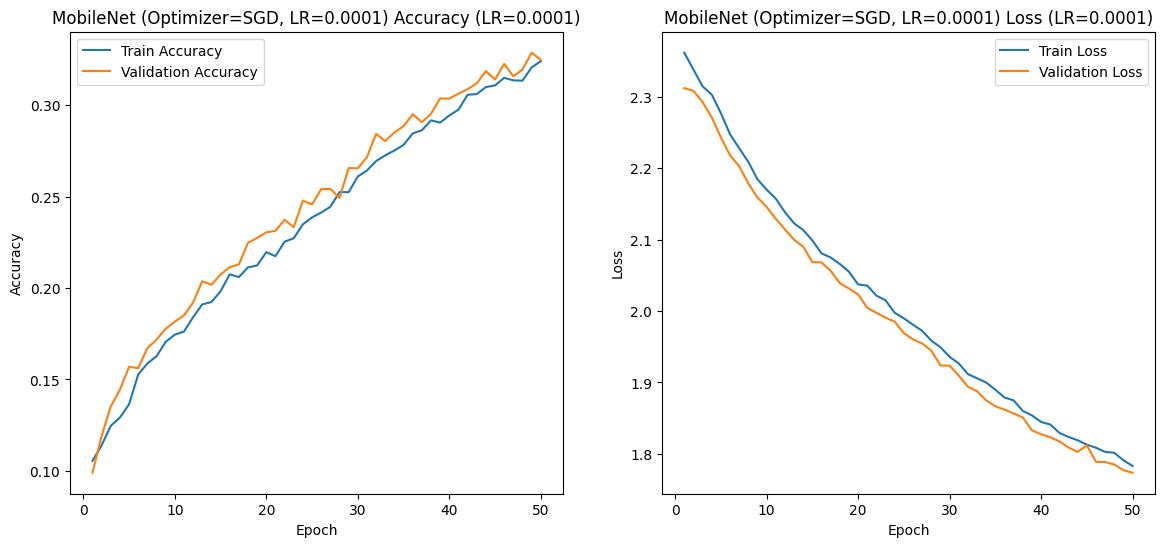

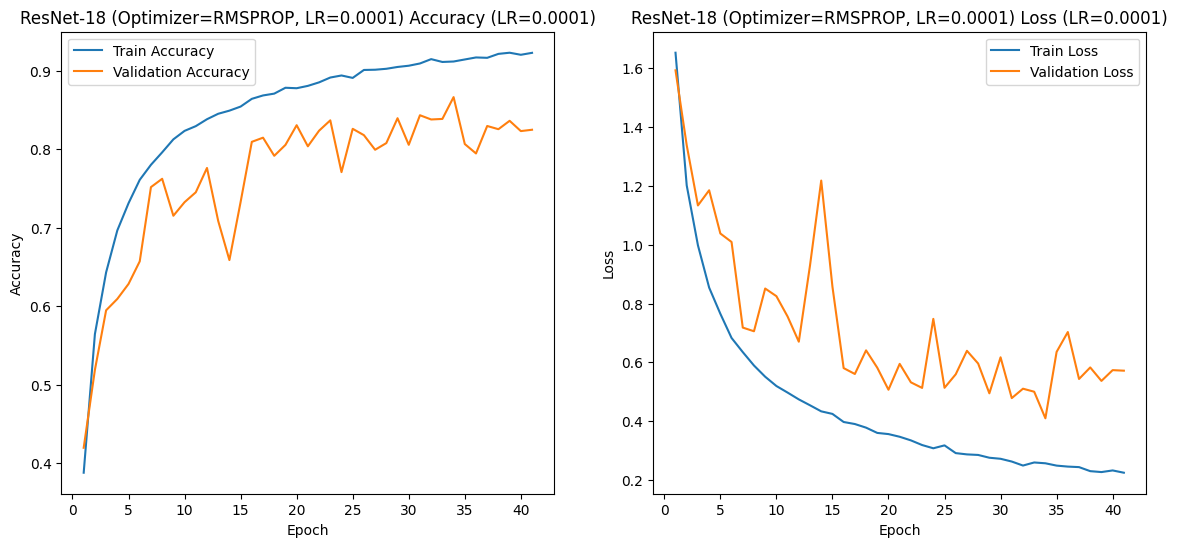

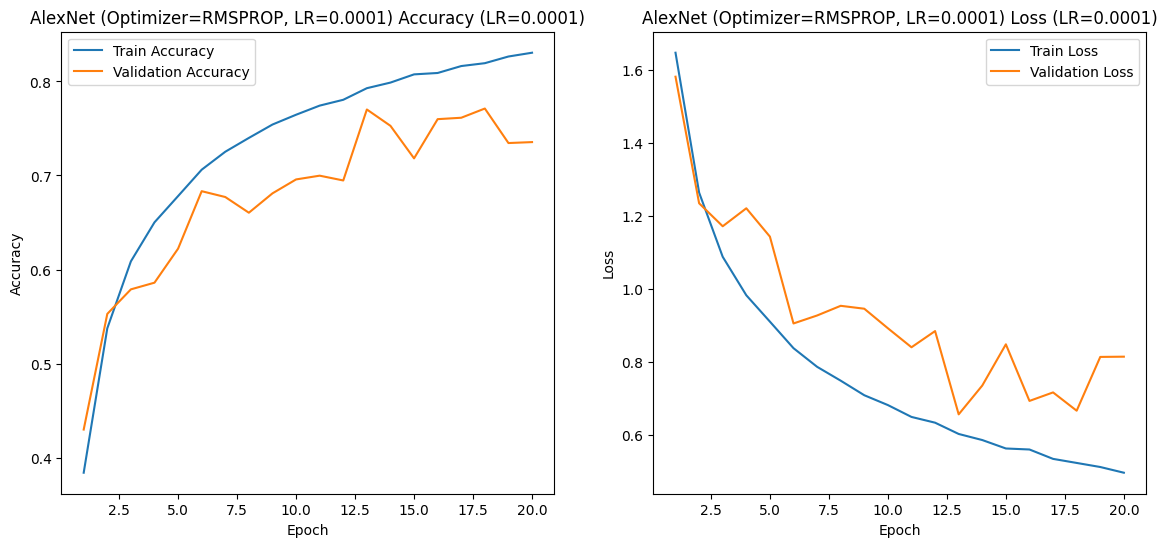

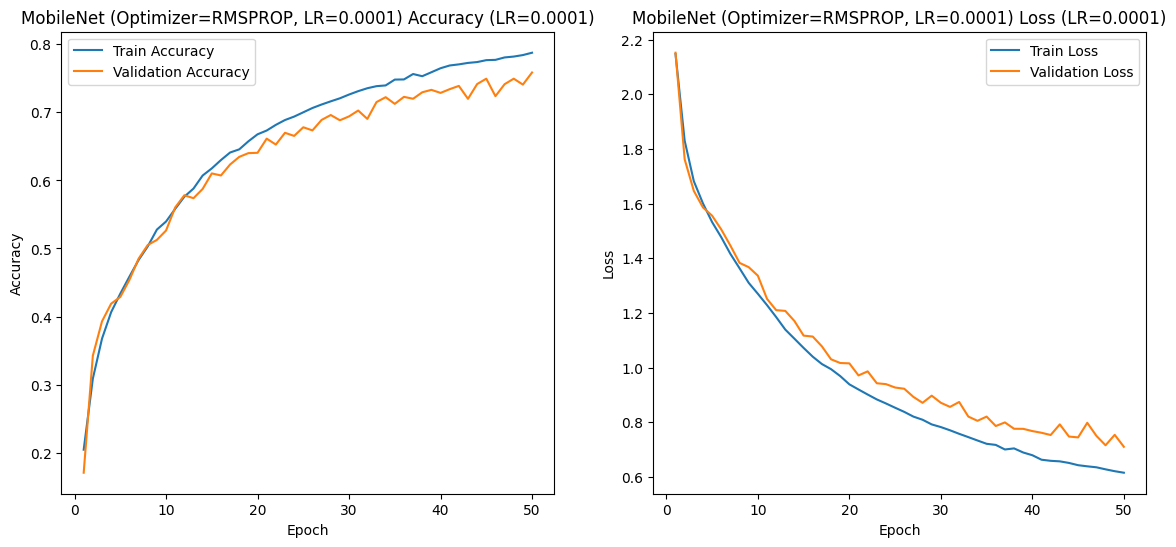

Best model: RESNET18 with optimizer ADAM and learning rate 0.001
Best Validation Accuracy: 0.8443
Best Validation Loss: 0.5071


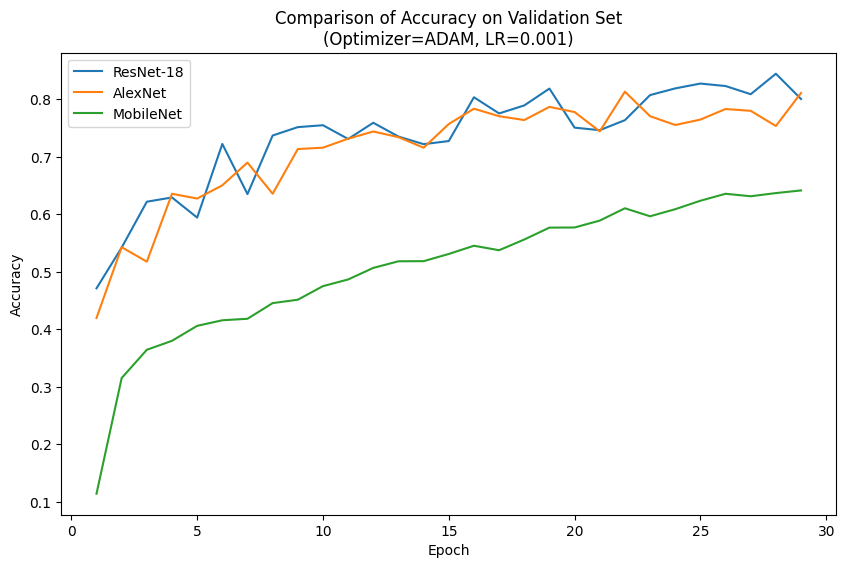

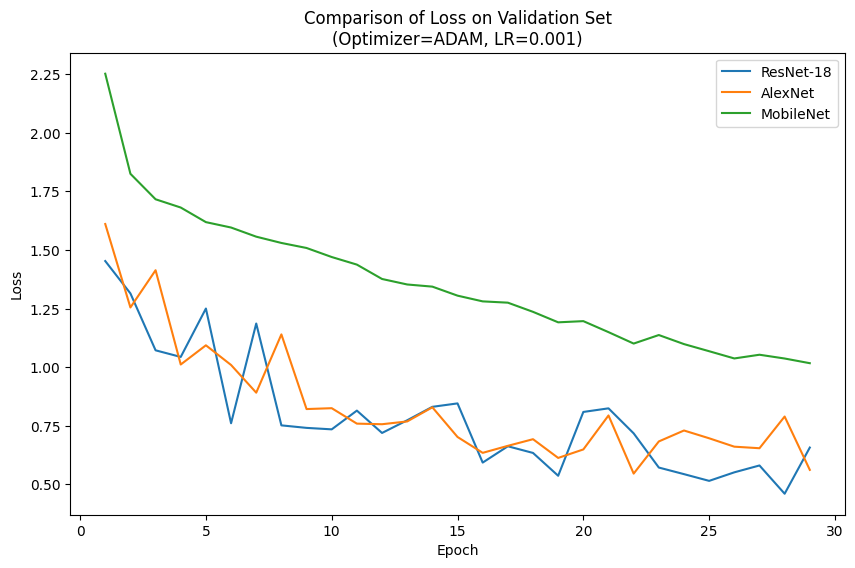

In [32]:
import matplotlib.pyplot as plt


# a. Plot and Analysis for each model, optimizer, and learning rate
for lr in learning_rates:
    for opt in optimizers_list:
        # Title for the optimizer and learning rate combination
        title_suffix = f"(Optimizer={opt.upper()}, LR={lr})"
        
        # Plot for ResNet-18
        plot_metrics(
            history[f'resnet18_{opt}_lr_{lr}']['train_acc'],
            history[f'resnet18_{opt}_lr_{lr}']['val_acc'],
            history[f'resnet18_{opt}_lr_{lr}']['train_loss'],
            history[f'resnet18_{opt}_lr_{lr}']['val_loss'],
            model_name=f'ResNet-18 {title_suffix}',
            lr=lr
        )

        # Plot for AlexNet
        plot_metrics(
            history[f'alexnet_{opt}_lr_{lr}']['train_acc'],
            history[f'alexnet_{opt}_lr_{lr}']['val_acc'],
            history[f'alexnet_{opt}_lr_{lr}']['train_loss'],
            history[f'alexnet_{opt}_lr_{lr}']['val_loss'],
            model_name=f'AlexNet {title_suffix}',
            lr=lr
        )

        # Plot for MobileNet
        plot_metrics(
            history[f'mobilenet_{opt}_lr_{lr}']['train_acc'],
            history[f'mobilenet_{opt}_lr_{lr}']['val_acc'],
            history[f'mobilenet_{opt}_lr_{lr}']['train_loss'],
            history[f'mobilenet_{opt}_lr_{lr}']['val_loss'],
            model_name=f'MobileNet {title_suffix}',
            lr=lr
        )

# b. Find the best combination of model, optimizer, and learning rate based on val_loss or val_acc
best_model = None
best_optimizer = None
best_lr = None
best_val_acc = 0
best_val_loss = float('inf')
best_history_key = None

for key, metrics in history.items():
    val_acc = metrics['val_acc'][-1]
    val_loss = metrics['val_loss'][-1]

    # Select based on highest val_acc 
    if val_acc > best_val_acc:  
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_history_key = key

# Get the best model, optimizer and learning rate from key
if best_history_key:
    parts = best_history_key.split('_')
    best_model = parts[0]  # Model: resnet18, alexnet, or mobilenet
    best_optimizer = parts[1]  # Optimizer: adam, sgd, or rmsprop
    best_lr = float(parts[-1].replace("lr_", ""))

# Show the best results
print(f"Best model: {best_model.upper()} with optimizer {best_optimizer.upper()} and learning rate {best_lr}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# c. Plot comparison of Accuracy and Loss on Validation Set between the best models
# Function for plotting comparison between three models
def plot_comparison_models(metric_resnet, metric_alexnet, metric_mobilenet, metric_name='Accuracy', dataset_type='Validation', optimizer='adam', lr=0.0001):
    # Find the smallest length of the three metrics
    min_length = min(len(metric_resnet), len(metric_alexnet), len(metric_mobilenet))
    
    # Cut the metric to the smallest length
    metric_resnet = metric_resnet[:min_length]
    metric_alexnet = metric_alexnet[:min_length]
    metric_mobilenet = metric_mobilenet[:min_length]
    
    # Determine the number of epochs based on the smallest length
    epochs = range(1, min_length + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metric_resnet, label='ResNet-18')
    plt.plot(epochs, metric_alexnet, label='AlexNet')
    plt.plot(epochs, metric_mobilenet, label='MobileNet')
    plt.title(f'Comparison of {metric_name} on {dataset_type} Set\n(Optimizer={optimizer.upper()}, LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Plot comparison of accuracy on validation set for best model
plot_comparison_models(
    history[f'resnet18_{best_optimizer}_lr_{best_lr}']['val_acc'],
    history[f'alexnet_{best_optimizer}_lr_{best_lr}']['val_acc'],
    history[f'mobilenet_{best_optimizer}_lr_{best_lr}']['val_acc'],
    metric_name='Accuracy',
    dataset_type='Validation',
    optimizer=best_optimizer,
    lr=best_lr
)

# Plot the loss comparison on the validation set for the best model
plot_comparison_models(
    history[f'resnet18_{best_optimizer}_lr_{best_lr}']['val_loss'],
    history[f'alexnet_{best_optimizer}_lr_{best_lr}']['val_loss'],
    history[f'mobilenet_{best_optimizer}_lr_{best_lr}']['val_loss'],
    metric_name='Loss',
    dataset_type='Validation',
    optimizer=best_optimizer,
    lr=best_lr
)


In [33]:
# Function to load model from saved file
def load_model(model_class, model_path):
    model_class.load_state_dict(torch.load(model_path)) # Load weights 
    model_class = model_class.to(device)  # Move the model to the appropriate device (GPU or CPU)
    return model_class

# Saved file path based on best model
model_path = f'saved_models/{best_model}_{best_optimizer}_best_lr_{best_lr}.pth'

# Load and evaluate the best model
if best_model == 'resnet18':
    model_instance = load_model(resnet18, model_path)
elif best_model == 'alexnet':
    model_instance = load_model(alexnet, model_path)
elif best_model == 'mobilenet':
    model_instance = load_model(mobilenet, model_path)
else:
    raise ValueError("Model tidak dikenal!")

# Evaluate the model on the test set
best_model_test_acc = evaluate_model(model_instance, model_name=best_model.upper())

# Print final accuracy for each model
print(f"Final Test Accuracy {best_model.upper()} (Optimizer={best_optimizer.upper()}, LR={best_lr}): {best_model_test_acc:.4f}")

Final Test Accuracy RESNET18 (Optimizer=ADAM, LR=0.001): 0.8804


# =================================================================
# 9. Displaying Final Accuracy on Test Set and Conclusion
# =================================================================

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1000
           1       0.96      0.93      0.94      1000
           2       0.79      0.87      0.83      1000
           3       0.85      0.72      0.78      1000
           4       0.90      0.89      0.90      1000
           5       0.76      0.91      0.83      1000
           6       0.93      0.91      0.92      1000
           7       0.95      0.90      0.92      1000
           8       0.88      0.96      0.92      1000
           9       0.89      0.95      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



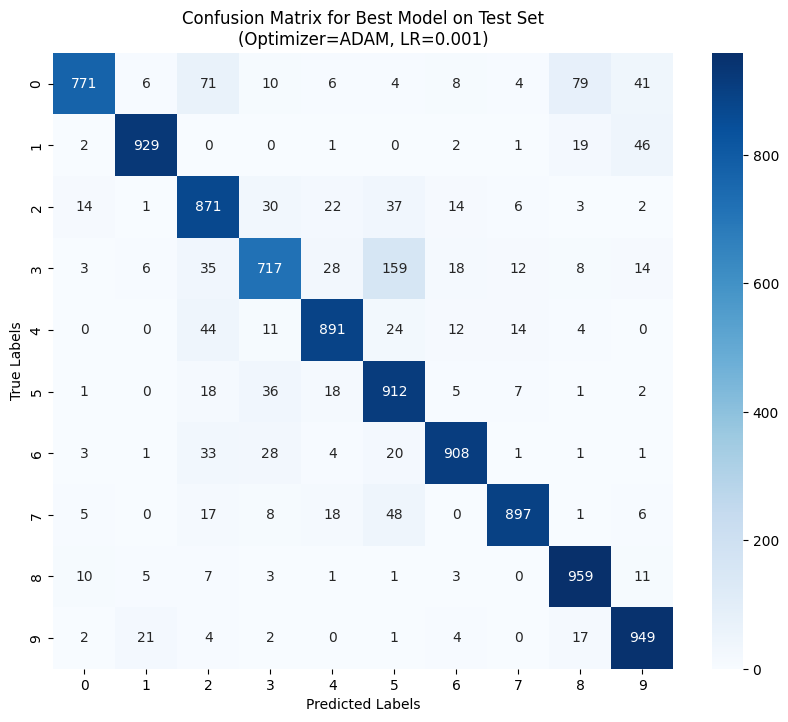

Class 0:
 - F1 Score : 0.8515
 - Precision : 0.9507
 - Recall : 0.7710
Class 1:
 - F1 Score : 0.9436
 - Precision : 0.9587
 - Recall : 0.9290
Class 2:
 - F1 Score : 0.8295
 - Precision : 0.7918
 - Recall : 0.8710
Class 3:
 - F1 Score : 0.7772
 - Precision : 0.8485
 - Recall : 0.7170
Class 4:
 - F1 Score : 0.8959
 - Precision : 0.9009
 - Recall : 0.8910
Class 5:
 - F1 Score : 0.8268
 - Precision : 0.7562
 - Recall : 0.9120
Class 6:
 - F1 Score : 0.9200
 - Precision : 0.9322
 - Recall : 0.9080
Class 7:
 - F1 Score : 0.9238
 - Precision : 0.9522
 - Recall : 0.8970
Class 8:
 - F1 Score : 0.9168
 - Precision : 0.8782
 - Recall : 0.9590
Class 9:
 - F1 Score : 0.9160
 - Precision : 0.8853
 - Recall : 0.9490


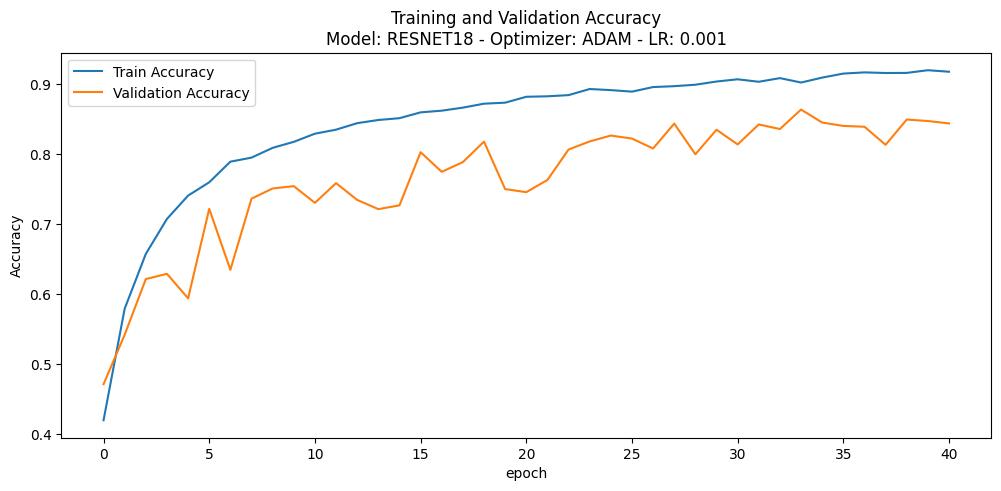

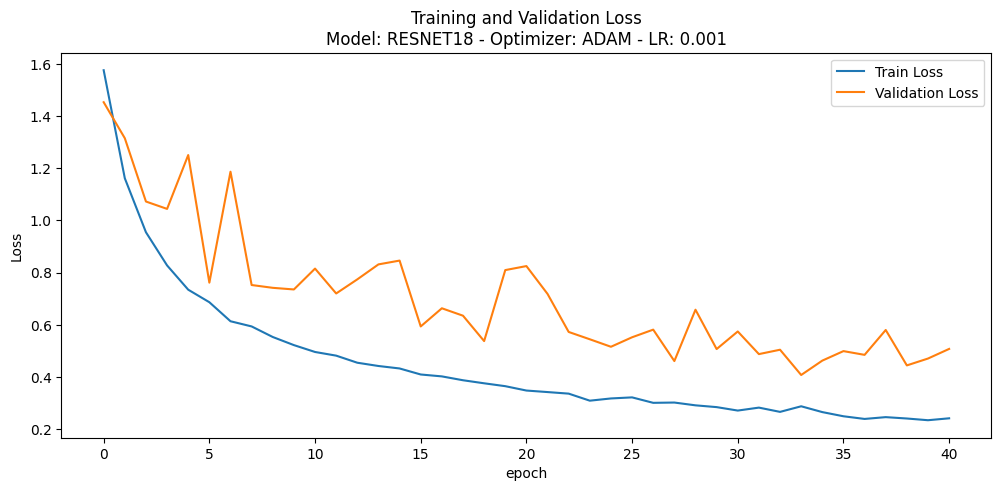

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve, auc
import torch

# Load the best model for evaluation on the test set
if best_model == 'resnet18':
    model_best = resnet18
elif best_model == 'alexnet':
    model_best = alexnet
elif best_model == 'mobilenet':
    model_best = mobilenet

# Load the best weights and move the model to the device used (GPU if available)
model_best.load_state_dict(torch.load(model_path))
model_best = model_best.to(device)
model_best.eval()

# Initialize list to store predicted and actual labels
all_preds = []
all_labels = []

# Perform predictions on the test set without calculating gradients
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_best(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Show classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title(f'Confusion Matrix for Best Model on Test Set\n(Optimizer={best_optimizer.upper()}, LR={best_lr})')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 1. Calculate F1-Score, Precision, and Recall per class
f1 = f1_score(all_labels, all_preds, average=None)
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Displays metrics per class
for i in range(num_classes):
    print(f"Class {i}:")
    print(f" - F1 Score : {f1[i]:.4f}")
    print(f" - Precision : {precision[i]:.4f}")
    print(f" - Recall : {recall[i]:.4f}")

# 2. Displays Loss and Accuracy curves on the Train and Validation Set
train_acc = history[best_history_key]['train_acc']
val_acc = history[best_history_key]['val_acc']
train_loss = history[best_history_key]['train_loss']
val_loss = history[best_history_key]['val_loss']


            
# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title(f"Training and Validation Accuracy\nModel: {best_model.upper()} - Optimizer: {best_optimizer.upper()} - LR: {best_lr}")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(12, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title(f"Training and Validation Loss\nModel: {best_model.upper()} - Optimizer: {best_optimizer.upper()} - LR: {best_lr}")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()